# Estonia - Tallin
# Date : 27th October - 30th October

In [1]:
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
!pip install chromedriver-autoinstaller
!pip install selenium-stealth

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading pack

In [10]:
import sys

sys.path.insert(0, "/usr/lib/chromium-browser/chromedriver")
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
import chromedriver_autoinstaller
from selenium_stealth import stealth
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import (
    TimeoutException,
    NoSuchElementException,
    StaleElementReferenceException,
)
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import time
from bs4 import BeautifulSoup
import requests
import ipywidgets as widgets
from IPython.display import display, clear_output
import io
from PIL import Image
import requests
from IPython.display import display, HTML
import base64

chromedriver_autoinstaller.install()

In [3]:
url = "https://www.kayak.com/hotels/Tallinn,Harjumaa,Estonia-c5753/2024-10-27/2024-10-30/2adults?sort=rank_a"

In [4]:
# Determining the number of nights of the stay in order to show total price and price per night
check_in_date, check_out_date = re.findall(r"\d\d\d\d-\d\d-\d\d", url)
number_of_nights = (pd.to_datetime(check_out_date) - pd.to_datetime(check_in_date)).days
print(number_of_nights)

3


Unfortunately we cannot see the whole notebook ran, because of too many requests the site recognized Masa's and Alexis' part as bots and we didn't find a way to overcome this issue, so we will be using data from csv file. We hope this is not a problem because we tried our best :(. Mete's part works fine so that will be ran. Masa's and Alexis' dataframe will be processed in Masa part

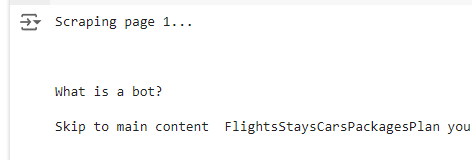

## Masa's part - Kayak website

In [21]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

stealth(
    driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="Win32",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)

In [14]:
driver.get(url)
driver.implicitly_wait(5)

### Web scraping

In [15]:
def process_property(driver, price):
    el = {}

    main_div = driver.find_element(By.CLASS_NAME, "eu4c")

    el["name"] = main_div.find_element(By.CLASS_NAME, "c3xth-hotel-name").text

    try:
        el["stars"] = (
            driver.find_element(By.CLASS_NAME, "c3xth-stars-in-title")
            .find_element(By.TAG_NAME, "span")
            .text.split()[0]
        )
    except:
        el["stars"] = None

    try:
        el["address"] = main_div.find_element(By.CLASS_NAME, "c3xth-address").text
    except:
        el["address"] = None

    h2_rating = driver.find_element(
        By.XPATH, '//*[@data-section-name="reviews"]'
    ).find_element(By.CLASS_NAME, "T_-S-section-header")
    if h2_rating.text == "Reviews":
        el["rating"] = driver.find_element(By.CLASS_NAME, "TnzK-score").text
        num_of_ratings = driver.find_element(By.CLASS_NAME, "TnzK-count").text
        number = num_of_ratings.split()[0]
        el["number of ratings"] = number
    else:
        el["rating"] = None
        el["number of ratings"] = 0

    # There are some propertys which need to be contacted, and so the regular price divs are missing
    if price:
        el["total price ($)"] = price
        el["price per night ($)"] = float(el["total price ($)"]) / number_of_nights
    else:
        el["total price ($)"] = None
        el["price per night ($)"] = None

    try:
        show_more_button = driver.find_element(
            By.CLASS_NAME, "b40a-inline-read-more-button"
        )
        driver.execute_script("arguments[0].click();", show_more_button)
        el["description"] = driver.find_element(
            By.CLASS_NAME, "b40a-desc-wrap--full"
        ).text
    except:
        try:
            el["description"] = driver.find_element(
                By.CLASS_NAME, "b40a-description-simple"
            ).text
        except:
            el["description"] = None

    el["images"] = []
    images = driver.find_elements(By.CLASS_NAME, "f800-image")
    for image in images:
        el["images"].append(image.get_attribute("src"))

    return el

In [16]:
# Scraping page py page
data = []
next_page = 2

while next_page != 16:
    properties = driver.find_elements(By.CLASS_NAME, "S0Ps")
    print(f"On page {next_page - 1}")
    print(f"Found {len(properties)} properties")

    for prop in properties:
        url = (
            prop.find_element(By.CLASS_NAME, "FLpo-hotel-name")
            .find_element(By.TAG_NAME, "a")
            .get_attribute("href")
        )
        price = None
        price_full_div = prop.find_element(By.CLASS_NAME, "zV27-price-section")

        try:
            price_div = price_full_div.find_element(By.CLASS_NAME, "c1XBO")
            price = price_div.text[1:].replace(",", "")
        except:
            pass

        data.append([url, price])

    page_text = f"Page {next_page}"
    next_page += 1
    try:
        next_page_button = driver.find_element(
            By.CSS_SELECTOR, f"[aria-label='{page_text}']"
        )
        driver.execute_script("arguments[0].click();", next_page_button)
    except:
        print("No more pages")
        break

On page 1
Found 0 properties
No more pages


In [94]:
properties_scraped = []

for url, price in data:
    driver.get(url)

    success = False
    for attempt in range(3):
        try:
            WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.CLASS_NAME, "eu4c"))
            )
            success = True
            break
        except:
            driver.refresh()

    if success:
        el = process_property(driver, price)
    else:
        print(f"Skipping {url}")

    print(el)
    properties_scraped.append(el)

In [ ]:
df_masa = pd.DataFrame(properties_scraped)
df_masa

In [23]:
# Here I will add one link just to demonstrate the processing part works well
demo_url = "https://www.kayak.com/hotels/Savoy-Boutique-Hotel-by-TallinnHotels,Tallinn-p6073-h157901-details/2024-10-27/2024-10-30/2adults?psid=cXGkBTjV5i&pm=totaltaxes#overview"
driver.get(demo_url)

el = process_property(driver, "188")
el

{'name': 'Savoy Boutique Hotel by TallinnHotels',
 'stars': '5',
 'address': '17 Suur-Karja, 10148 Tallinn, Harjumaa',
 'rating': '8.7',
 'number of ratings': '2287',
 'total price ($)': '188',
 'price per night ($)': 62.666666666666664,
 'description': None,
 'images': ['https://content.r9cdn.net/rimg/himg/45/ee/28/expedia_group-157901-6f75ca-938689.jpg?width=1020&height=1020&xhint=1120&yhint=629&crop=true&watermarkheight=28&watermarkpadding=10',
  'https://content.r9cdn.net/rimg/himg/35/5a/1b/expedia_group-157901-47eb79-193518.jpg?width=1020&height=1020&xhint=520&yhint=333&crop=true&watermarkheight=28&watermarkpadding=10',
  'https://content.r9cdn.net/rimg/himg/a5/68/d6/expedia_group-157901-e448bc-294197.jpg?width=1020&height=1020&xhint=540&yhint=333&crop=true&watermarkheight=28&watermarkpadding=10',
  'https://content.r9cdn.net/rimg/himg/24/fc/e8/expedia_group-157901-7370ca37-671841.jpg?width=1020&height=1020&xhint=480&yhint=333&crop=true&watermarkheight=28&watermarkpadding=10',
  '

In [ ]:
driver.quit()

### Data processing

In [96]:
df_masa = pd.read_csv("properties_dataframe.csv")
df_alexis = pd.read_csv("properties_dataframe.csv")
df_masa

,name,address,stars,rating,number of ratings,total price ($),price per night ($),description,images
0,Savoy Boutique Hotel by TallinnHotels,"17 Suur-Karja, 10148 Tallinn, Harjumaa",5,8.7,2283,55,18.33,Luxury Art Deco hotel near Port of Tallinn A b...,['https://content.r9cdn.net/rimg/himg/0b/cc/8f...
1,Hotel Bern by TallinnHotels,"Aia 10, 10111 Tallinn, Harjumaa",5,8.3,3494,46,15.33,"Warm welcome, cosy atmosphere and modern accom...",['https://content.r9cdn.net/rimg/himg/2c/f5/7c...
2,Swissotel Tallinn,"Tornimae 3, 10145 Tallinn, Harjumaa",3,8.9,3599,101,33.67,Swissôtel Tallinn is conveniently located just...,['https://content.r9cdn.net/rimg/himg/6c/5f/e2...
3,Oru Hub Hotel Tallinn - Handwritten Collection,"Narva Mnt 120 B, 10127 Tallinn, Harjumaa",3,9.2,2836,61,20.33,The Oru Hub Hotel is perfectly located close t...,['https://content.r9cdn.net/rimg/himg/48/0b/73...
4,Rija Fonnental Design Hotel Tallinn,"13a L. Koidula, 10150 Tallinn, Harjumaa",5,8.6,1408,48,16.00,"Located in the centre of Tallinn, Rija Fonnent...",['https://content.r9cdn.net/rimg/himg/9c/dd/1a...
...,...,...,...,...,...,...,...,...,...
338,Rotermanni Mere Apartment,Kesklinn,4,8.7,92,55,18.33,Located within 1 km of Kalarand and 2.2 km of ...,['https://content.r9cdn.net/rimg/himg/53/fd/81...
339,EasyRentals Central Tallinn Apartments by Tall...,Kesklinn,3,7.9,57,42,14.00,EasyRentals Central Tallinn Apartments by Tall...,['https://content.r9cdn.net/rimg/himg/fa/9d/60...
340,Harmoonikum,"8 Pargi tee, 74001 Viimsi, Harjumaa",3,7.7,5,73,24.33,"Featuring a garden and views of quiet street, ...",['https://content.r9cdn.net/rimg/himg/b9/be/dd...
341,The Monks Bunk Hostel & Bar,"Lai 22, 10133 Tallinn, Harjumaa",3,7.9,1259,97,32.33,Located in Tallinn and with Kalarand reachable...,['https://content.r9cdn.net/rimg/himg/c1/88/7e...


In [97]:
df_masa.isna().sum()

,0
name,0
address,0
stars,0
rating,0
number of ratings,0
total price ($),0
price per night ($),0
description,0
images,0


In [98]:
# Replacing empty lists in the 'images' column with None
df_masa["images"] = df_masa["images"].apply(lambda x: None if len(x) == 0 else x)

# Converting numeric columns to numeric type, handling potential errors
df_masa["total price ($)"] = pd.to_numeric(
    df_masa["total price ($)"], errors="coerce", downcast="float"
)
df_masa["price per night ($)"] = pd.to_numeric(
    df_masa["price per night ($)"], errors="coerce", downcast="float"
)
df_masa["price per night ($)"] = df_masa["price per night ($)"].apply(
    lambda x: round(x, 2)
)
df_masa["rating"] = pd.to_numeric(df_masa["rating"], errors="coerce", downcast="float")
df_masa["rating"] = df_masa["rating"].apply(
    lambda x: round(x, 2)
)

df_masa["number of ratings"] = pd.to_numeric(
    df_masa["number of ratings"], errors="coerce", downcast="integer"
)
df_masa["stars"] = pd.to_numeric(df_masa["stars"], errors="coerce", downcast="integer")
df_masa

,name,address,stars,rating,number of ratings,total price ($),price per night ($),description,images
0,Savoy Boutique Hotel by TallinnHotels,"17 Suur-Karja, 10148 Tallinn, Harjumaa",5,8.7,2283,55.0,18.33,Luxury Art Deco hotel near Port of Tallinn A b...,['https://content.r9cdn.net/rimg/himg/0b/cc/8f...
1,Hotel Bern by TallinnHotels,"Aia 10, 10111 Tallinn, Harjumaa",5,8.3,3494,46.0,15.33,"Warm welcome, cosy atmosphere and modern accom...",['https://content.r9cdn.net/rimg/himg/2c/f5/7c...
2,Swissotel Tallinn,"Tornimae 3, 10145 Tallinn, Harjumaa",3,8.9,3599,101.0,33.67,Swissôtel Tallinn is conveniently located just...,['https://content.r9cdn.net/rimg/himg/6c/5f/e2...
3,Oru Hub Hotel Tallinn - Handwritten Collection,"Narva Mnt 120 B, 10127 Tallinn, Harjumaa",3,9.2,2836,61.0,20.33,The Oru Hub Hotel is perfectly located close t...,['https://content.r9cdn.net/rimg/himg/48/0b/73...
4,Rija Fonnental Design Hotel Tallinn,"13a L. Koidula, 10150 Tallinn, Harjumaa",5,8.6,1408,48.0,16.00,"Located in the centre of Tallinn, Rija Fonnent...",['https://content.r9cdn.net/rimg/himg/9c/dd/1a...
...,...,...,...,...,...,...,...,...,...
338,Rotermanni Mere Apartment,Kesklinn,4,8.7,92,55.0,18.33,Located within 1 km of Kalarand and 2.2 km of ...,['https://content.r9cdn.net/rimg/himg/53/fd/81...
339,EasyRentals Central Tallinn Apartments by Tall...,Kesklinn,3,7.9,57,42.0,14.00,EasyRentals Central Tallinn Apartments by Tall...,['https://content.r9cdn.net/rimg/himg/fa/9d/60...
340,Harmoonikum,"8 Pargi tee, 74001 Viimsi, Harjumaa",3,7.7,5,73.0,24.33,"Featuring a garden and views of quiet street, ...",['https://content.r9cdn.net/rimg/himg/b9/be/dd...
341,The Monks Bunk Hostel & Bar,"Lai 22, 10133 Tallinn, Harjumaa",3,7.9,1259,97.0,32.33,Located in Tallinn and with Kalarand reachable...,['https://content.r9cdn.net/rimg/himg/c1/88/7e...


## Mete's part - Booking.com

### Web Scraping

In [30]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

stealth(
    driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="Win32",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)

In [31]:
driver.get(
    "https://www.booking.com/searchresults.html?ss=Tallinn&ssne=Tallinn&ssne_untouched=Tallinn&label=gen173nr-1FCAEoggI46AdIM1gEaEiIAQGYATG4ARfIAQzYAQHoAQH4AQKIAgGoAgO4Atrp8LcGwAIB0gIkNjg1OGI1YzUtYmZkNi00NDAwLTg4YjAtOTU4ZDA2NjZiNzlh2AIF4AIB&aid=304142&lang=en-us&sb=1&src_elem=sb&src=index&dest_id=-2625660&dest_type=city&checkin=2024-10-27&checkout=2024-10-30&group_adults=1&no_rooms=1&group_children=0&sr_view=grid&selected_currency=USD"
)

In [32]:
property_links = []

# Scroll to the bottom multiple times to load more elements
while True:
    property_elements = driver.find_elements(By.CSS_SELECTOR, '.d851610c87 a')

    # Add the links to the list
    for el in property_elements:
        href = el.get_attribute('href')
        if href not in property_links:  # Avoid duplicates
            property_links.append(href)

    # Scroll down to load more properties
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)  # Wait for new content to load

    # Stop if the number of links doesn't increase anymore
    if len(property_links) >= 100:
        break

In [33]:
property_data = []
i = 1
print(len(property_links))
for link in property_links:
    print(i)
    i += 1
    driver.get(link)
    property_info = {}

    try:
        property_name_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (
                    By.CSS_SELECTOR,
                    '[data-capla-component-boundary="b-property-web-property-page/PropertyHeaderName"]',
                )
            )
        )
        property_name = property_name_element.text
        property_info["name"] = property_name
    except Exception as e:
        print(f"Could not find property name for {link}. Error: {str(e)}")
        property_info["name"] = None

    try:
        rating_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "[data-review-score]"))
        )
        rating = rating_element.get_attribute("data-review-score")
        property_info["rating"] = rating
    except Exception as e:
        property_info["rating"] = None
        print(f"Could not find rating for {link}. Error: {str(e)}")

    try:
        price_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, ".prco-valign-middle-helper")
            )
        )
        price = price_element.text
        property_info["total price ($)"] = price
    except Exception as e:
        property_info["total price ($)"] = None
        print(f"Could not find price for {link}. Error: {str(e)}")

    try:
        review_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, '[data-testid="review-score-right-component"]')
            )
        )
        review_text = review_element.text
        review_words = review_text.split()
        if len(review_words) >= 2:
            second_last_word = review_words[-2]
            property_info["number of ratings"] = second_last_word
        else:
            property_info["number of ratings"] = None
    except Exception as e:
        property_info["number of ratings"] = None
        print(f"Could not find review for {link}. Error: {str(e)}")

    try:
        summary_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, '[data-testid="property-description"]')
            )
        )
        property_info["description"] = summary_element.text
    except Exception as e:
        property_info["description"] = None
        print(f"Could not find review for {link}. Error: {str(e)}")

    try:
        address_element = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, '[data-node_tt_id="location_score_tooltip"]')
            )
        )
        property_info["address"] = address_element.text
    except Exception as e:
        property_info["address"] = None
        print(f"Could not find review for {link}. Error: {str(e)}")

    html_content = driver.page_source
    soup = BeautifulSoup(html_content, 'html.parser')
    containers_main = soup.find_all('div', class_='bui-inline-container__main')
    text = ""
    try:
      last_container_main = containers_main[-1]
      text += last_container_main.get_text(strip=True)
      match1 = re.search(r'(\w+)-star', text)
      if match1:
          word_before_star = match1.group(1)
          if word_before_star == 'one':
            property_info['stars'] = 1
          elif word_before_star == 'two':
            property_info['stars'] = 2
          elif word_before_star == 'three':
            property_info['stars'] = 3
          elif word_before_star == 'four':
            property_info['stars'] = 4
          elif word_before_star == 'five':
            property_info['stars'] = 5
    except Exception as e:
      # Interestingly, the program sometimes cannot find the value, and it is only for the three-star hotels.
      property_info['stars'] = 3


    try:
        image_elements = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, ".bh-photo-grid img"))
        )
        image_links = [img.get_attribute("src") for img in image_elements[:4]]
        property_info["images"] = image_links
    except Exception as e:
        property_info["images"] = None
        print(f"Could not find image links for {link}. Error: {str(e)}")

    property_data.append(property_info)

df_mete = pd.DataFrame(property_data)

117
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117


In [34]:
driver.quit()

### Data Preprocessing

In [61]:
df_mete.isna().sum()

,0
name,0
rating,0
total price ($),0
number of ratings,0
description,0
address,0
images,0
stars,55


In [62]:
df_mete["total price ($)"] = df_mete["total price ($)"].str[1:]
df_mete["total price ($)"] = pd.to_numeric(
    df_mete["total price ($)"].str.replace(",", ""), errors="coerce", downcast="float"
)

df_mete["price per night ($)"] = (
    df_mete["total price ($)"] / 3
)
df_mete["price per night ($)"] = pd.to_numeric(
    df_mete["price per night ($)"], errors="coerce", downcast="float"
)
df_mete["price per night ($)"] = df_mete["price per night ($)"].apply(
    lambda x: round(x, 2)
)

df_mete["number of ratings"] = (
    df_mete["number of ratings"].str.replace(",", "")
)
df_mete["number of ratings"] = pd.to_numeric(
    df_mete["number of ratings"], errors="coerce", downcast="integer"
)

df_mete["rating"] = pd.to_numeric(df_mete["rating"], errors="coerce", downcast="float")
df_mete["rating"] = df_mete["rating"].apply(
    lambda x: round(x, 2)
)

df_mete["stars"] = pd.to_numeric(df_mete["stars"], errors="coerce", downcast="integer")

df_mete["images"] = df_mete["images"].str[1:-1]
new_order = [
    "name",
    "stars",
    "address",
    "rating",
    "number of ratings",
    "total price ($)",
    "price per night ($)",
    "description",
    "images",
]
df_mete = df_mete[new_order]
df_mete

,name,stars,address,rating,number of ratings,total price ($),price per night ($),description,images
0,Revelton Suites Tallinn,NaN,"EHA 6, Tallinn City Center, 10137 Tallinn, Est...",9.7,1904,202.0,67.33,"Revelton Suites is set in central Tallinn, wit...",[https://cf.bstatic.com/xdata/images/hotel/max...
1,Citybox Tallinn City Center,3.0,"Laeva 1, Tallinn City Center, 10151 Tallinn, E...",8.9,20951,129.0,43.00,Citybox Tallinn City Center is located in the ...,[https://cf.bstatic.com/xdata/images/hotel/max...
2,My City Hotel,4.0,"Vana-Posti 11/13, Tallinn City Center, 10146 T...",8.8,1777,235.0,78.33,The 4-star My City Hotel is located in Tallinn...,[https://cf.bstatic.com/xdata/images/hotel/max...
3,Bob W Kesklinn,NaN,"Veski tn 1, Tallinn City Center, 10118 Tallinn...",9.7,494,157.0,52.33,Bob W Kesklinn features accommodations within ...,[https://cf.bstatic.com/xdata/images/hotel/max...
4,Medieval Home,NaN,"Vene tn 10-9, Tallinn City Center, 10123 Talli...",8.5,146,116.0,38.67,Just a 2-minute walk from Tallinn Town Hall an...,[https://cf.bstatic.com/xdata/images/hotel/max...
...,...,...,...,...,...,...,...,...,...
112,Tallink Express Hotel,3.0,"Sadama 9, Tallinn City Center, 10111 Tallinn, ...",7.6,5309,153.0,51.00,The comfortable hotel with friendly rates and ...,[https://cf.bstatic.com/xdata/images/hotel/max...
113,Tallinn Oasis Studios by RevalHome,NaN,"23 Majaka, Lasnamae, 11416 Tallinn, Estonia",8.0,612,177.0,59.00,Tallinn Oasis Studios by RevalHome offers acco...,[https://cf.bstatic.com/xdata/images/hotel/max...
114,Bob W Telliskivi,NaN,"Telliskivi 49, Põhja-Tallinn, 10412 Tallinn, E...",9.2,1136,152.0,50.67,Just 1.2 miles from Kalarand and a 11-minute w...,[https://cf.bstatic.com/xdata/images/hotel/max...
115,Hotel Rocca al Mare,4.0,"Vabaõhumuuseumi tee 11/ Lillevälja 2, Haaberst...",7.6,3891,132.0,44.00,"Located on the coast of the Baltic Sea, this 4...",[https://cf.bstatic.com/xdata/images/hotel/max...


## Alexis' part - Momondo

In [67]:
options = webdriver.ChromeOptions()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

stealth(
    driver,
    languages=["en-US", "en"],
    vendor="Google Inc.",
    platform="Win32",
    webgl_vendor="Intel Inc.",
    renderer="Intel Iris OpenGL Engine",
    fix_hairline=True,
)

In [68]:
url = "https://www.momondo.com/hotel-search/Tallinna,Viro-p6073/2024-10-07/2024-10-09/2adults?sort=rank_a"
driver.get(url=url)
driver.implicitly_wait(5)

In [69]:
page_sources = []
pages = 10
next_page = 1

try:
  WebDriverWait(driver, 20).until(
      EC.element_to_be_clickable((By.CSS_SELECTOR, "button:has(> .RxNS-button-container)"))
  )
  buttons = driver.find_elements(By.CSS_SELECTOR, "button:has(> .RxNS-button-container)")
  button = buttons[2]
  print(button)

  button.click()

except TimeoutException as e:
  print("Cookie consent popup not found")

url_price = []
for i in range(1, pages + 1):
  print(f"Page {i}")

  try:
    properties = driver.find_elements(By.CLASS_NAME, "S0Ps")

    print(f"Found {len(properties)} properties")

    for prop in properties:
      url = prop.find_element(By.CLASS_NAME, "FLpo-hotel-name").find_element(By.TAG_NAME, "a").get_attribute("href")
      price = None
      div = prop.find_element(By.CLASS_NAME, "S0Ps-middleSection")

      try:
        price_div = div.find_element(By.CLASS_NAME, "Ptt7-price")
        price = price_div.text[1:].replace(",", "")
      except:
        pass

      url_price.append([url, price])
  except TimeoutException as e:
    print(f'Error occurred {e.message}')

  next_page += 1
  try:
    print("Finding next page...")

    next_page_button = driver.find_element(By.CSS_SELECTOR, f"[aria-label='Page {next_page}']")
    driver.execute_script("arguments[0].click();", next_page_button)
  except Exception as e:
    print(f'An exception occurred when clicking next: {e}')


Cookie consent popup not found
Page 1
Found 0 properties
Finding next page...
An exception occurred when clicking next: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[aria-label='Page 2']"}
  (Session info: chrome=129.0.6668.89); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
#0 0x5b3397afe02a <unknown>
#1 0x5b33977e45e0 <unknown>
#2 0x5b3397833be8 <unknown>
#3 0x5b3397833e81 <unknown>
#4 0x5b339787a8c4 <unknown>
#5 0x5b3397858b4d <unknown>
#6 0x5b3397877d7d <unknown>
#7 0x5b33978588c3 <unknown>
#8 0x5b33978266b3 <unknown>
#9 0x5b339782768e <unknown>
#10 0x5b3397ac8a2b <unknown>
#11 0x5b3397acc9b1 <unknown>
#12 0x5b3397ab5225 <unknown>
#13 0x5b3397acd532 <unknown>
#14 0x5b3397a9a38f <unknown>
#15 0x5b3397aecf28 <unknown>
#16 0x5b3397aed0f3 <unknown>
#17 0x5b3397afce7c <unknown>
#18 0x784f7555fac3 <unknown>

Page 2


KeyboardInterrupt: 

In [ ]:
momondo_scraped = []

for url, price in url_price:
  driver.get(url)

  success = False
  for attempt in range(3):
      try:
          WebDriverWait(driver, 20).until(
              EC.presence_of_element_located((By.CLASS_NAME, "eu4c"))
          )
          success = True
          break
      except:
          driver.refresh()

  if success:
      el = process_property(driver, price)
  else:
      print(f"Skipping {url}")

  print(el)
  momondo_scraped.append(el)

{'name': 'Park Inn by Radisson Meriton Conference&Spa Tallin', 'stars': '4', 'address': 'Toompuiestee 27, 10149 Tallinn, Harjumaa', 'rating': '8.2', 'number of ratings': '6268', 'total price ($)': '64', 'price per night ($)': 21.333333333333332, 'description': "Upscale spa hotel, a quick walk to Alexander Nevsky Cathedral Along with a full-service spa, this smoke-free hotel has an indoor pool and a restaurant. WiFi in public areas is free. Other amenities include 2 bars/lounges, a fitness center, and a poolside bar. Change of towels is available on request. Park Inn by Radisson Meriton Conference & Spa Hotel Tallinn offers 465 accommodations with safes and coffee/tea makers. Flat-screen televisions come with satellite channels. Bathrooms include bathtubs or showers, bathrobes, and hair dryers. Guests can surf the web using the complimentary wireless Internet access. Business-friendly amenities include desks and phones. Change of towels and change of bedsheets can be requested. Housekee

KeyboardInterrupt: 

In [ ]:
driver.quit()

In [ ]:
df_alexis = pd.DataFrame(properties_scraped)
df_alexis

### Data Preprocessing

In [ ]:
df_alexis.isna().sum()

In [ ]:
# Replacing empty lists in the 'images' column with None
df_alexis["images"] = df_alexis["images"].apply(lambda x: None if len(x) == 0 else x)
# Removing " from urls
df_alexis["images"] = df_alexis["images"].str[1:-1].str.replace("'", "")

# Converting numeric columns to numeric type, handling potential errors
df_alexis["total price ($)"] = pd.to_numeric(
    df_alexis["total price ($)"], errors="coerce", downcast="float"
)
df_alexis["price per night ($)"] = pd.to_numeric(
    df_alexis["price per night ($)"], errors="coerce", downcast="float"
)
df_alexis["price per night ($)"] = df_alexis["price per night ($)"].apply(
    lambda x: round(x, 2)
)
df_alexis["rating"] = pd.to_numeric(df_alexis["rating"], errors="coerce", downcast="float")
df_alexis["number of ratings"] = pd.to_numeric(
    df_alexis["number of ratings"], errors="coerce", downcast="integer"
)
df_alexis["stars"] = pd.to_numeric(df_alexis["stars"], errors="coerce", downcast="integer")
df_alexis

## Combined

In [142]:
# If you want to use the provided csv file, upload it to the session storage and skip this step
properties_dataframe = pd.concat([df_masa, df_mete, df_alexis], ignore_index=True)
properties_dataframe.drop_duplicates(subset='name', inplace=True)
properties_dataframe.reset_index(drop=True, inplace=True)
properties_dataframe.to_csv("full_properties_dataframe.csv", index=False)
properties_dataframe

,name,address,stars,rating,number of ratings,total price ($),price per night ($),description,images
0,Savoy Boutique Hotel by TallinnHotels,"17 Suur-Karja, 10148 Tallinn, Harjumaa",5.0,8.7,2283,55.0,18.33,Luxury Art Deco hotel near Port of Tallinn A b...,['https://content.r9cdn.net/rimg/himg/0b/cc/8f...
1,Hotel Bern by TallinnHotels,"Aia 10, 10111 Tallinn, Harjumaa",5.0,8.3,3494,46.0,15.33,"Warm welcome, cosy atmosphere and modern accom...",['https://content.r9cdn.net/rimg/himg/2c/f5/7c...
2,Swissotel Tallinn,"Tornimae 3, 10145 Tallinn, Harjumaa",3.0,8.9,3599,101.0,33.67,Swissôtel Tallinn is conveniently located just...,['https://content.r9cdn.net/rimg/himg/6c/5f/e2...
3,Oru Hub Hotel Tallinn - Handwritten Collection,"Narva Mnt 120 B, 10127 Tallinn, Harjumaa",3.0,9.2,2836,61.0,20.33,The Oru Hub Hotel is perfectly located close t...,['https://content.r9cdn.net/rimg/himg/48/0b/73...
4,Rija Fonnental Design Hotel Tallinn,"13a L. Koidula, 10150 Tallinn, Harjumaa",5.0,8.6,1408,48.0,16.00,"Located in the centre of Tallinn, Rija Fonnent...",['https://content.r9cdn.net/rimg/himg/9c/dd/1a...
...,...,...,...,...,...,...,...,...,...
356,"Thomas' Home - Trendy, Central & Balcony","Narva maantee 40 street, Tallinn City Center, ...",NaN,8.7,641,158.0,52.67,"1.4 miles from Kalarand in Tallinn, Thomas' Ho...",[https://cf.bstatic.com/xdata/images/hotel/max...
357,Room near City Center Harbour,"54 Tuukri, Tallinn City Center, 10120 Tallinn,...",NaN,8.1,214,97.0,32.33,Room near City Center Harbour offers accommoda...,[https://cf.bstatic.com/xdata/images/hotel/max...
358,Hotel L'Ermitage,"Toompuiestee 19, Tallinn City Center, 10137 Ta...",3.0,8.5,4394,168.0,56.00,The modern 4-star Hotel L’Ermitage is located ...,[https://cf.bstatic.com/xdata/images/hotel/max...
359,Adoryal Hotell,"5 Kai, Tallinn City Center, 10111 Tallinn, Est...",3.0,8.4,3679,195.0,65.00,"Well located in the center of Tallinn, Adoryal...",[https://cf.bstatic.com/xdata/images/hotel/max...


In [143]:
properties_dataframe = pd.read_csv("full_properties_dataframe.csv")
properties_dataframe.loc[properties_dataframe.index, "images"] = properties_dataframe["images"].apply(lambda x: eval(x))
properties_dataframe

,name,address,stars,rating,number of ratings,total price ($),price per night ($),description,images
0,Savoy Boutique Hotel by TallinnHotels,"17 Suur-Karja, 10148 Tallinn, Harjumaa",5.0,8.7,2283,55.0,18.33,Luxury Art Deco hotel near Port of Tallinn A b...,[https://content.r9cdn.net/rimg/himg/0b/cc/8f/...
1,Hotel Bern by TallinnHotels,"Aia 10, 10111 Tallinn, Harjumaa",5.0,8.3,3494,46.0,15.33,"Warm welcome, cosy atmosphere and modern accom...",[https://content.r9cdn.net/rimg/himg/2c/f5/7c/...
2,Swissotel Tallinn,"Tornimae 3, 10145 Tallinn, Harjumaa",3.0,8.9,3599,101.0,33.67,Swissôtel Tallinn is conveniently located just...,[https://content.r9cdn.net/rimg/himg/6c/5f/e2/...
3,Oru Hub Hotel Tallinn - Handwritten Collection,"Narva Mnt 120 B, 10127 Tallinn, Harjumaa",3.0,9.2,2836,61.0,20.33,The Oru Hub Hotel is perfectly located close t...,[https://content.r9cdn.net/rimg/himg/48/0b/73/...
4,Rija Fonnental Design Hotel Tallinn,"13a L. Koidula, 10150 Tallinn, Harjumaa",5.0,8.6,1408,48.0,16.00,"Located in the centre of Tallinn, Rija Fonnent...",[https://content.r9cdn.net/rimg/himg/9c/dd/1a/...
...,...,...,...,...,...,...,...,...,...
356,"Thomas' Home - Trendy, Central & Balcony","Narva maantee 40 street, Tallinn City Center, ...",NaN,8.7,641,158.0,52.67,"1.4 miles from Kalarand in Tallinn, Thomas' Ho...",[https://cf.bstatic.com/xdata/images/hotel/max...
357,Room near City Center Harbour,"54 Tuukri, Tallinn City Center, 10120 Tallinn,...",NaN,8.1,214,97.0,32.33,Room near City Center Harbour offers accommoda...,[https://cf.bstatic.com/xdata/images/hotel/max...
358,Hotel L'Ermitage,"Toompuiestee 19, Tallinn City Center, 10137 Ta...",3.0,8.5,4394,168.0,56.00,The modern 4-star Hotel L’Ermitage is located ...,[https://cf.bstatic.com/xdata/images/hotel/max...
359,Adoryal Hotell,"5 Kai, Tallinn City Center, 10111 Tallinn, Est...",3.0,8.4,3679,195.0,65.00,"Well located in the center of Tallinn, Adoryal...",[https://cf.bstatic.com/xdata/images/hotel/max...


In [144]:
properties_dataframe.describe()

,stars,rating,number of ratings,total price ($),price per night ($)
count,352.000000,361.000000,361.000000,361.000000,361.000000
mean,4.045455,8.662050,872.443213,90.759003,30.253158
std,0.811724,0.796154,1467.388166,52.225367,17.408457
min,3.000000,4.400000,1.000000,21.000000,7.000000
25%,3.000000,8.200000,23.000000,57.000000,19.000000
50%,4.000000,8.800000,128.000000,79.000000,26.330000
75%,5.000000,9.200000,1005.000000,103.000000,34.330000
max,5.000000,10.000000,7317.000000,462.000000,154.000000


In [147]:
no_nan_df = properties_dataframe.dropna()
no_nan_df.describe()

,stars,rating,number of ratings,total price ($),price per night ($)
count,352.000000,352.000000,352.000000,352.000000,352.000000
mean,4.045455,8.660511,882.417614,88.911932,29.637472
std,0.811724,0.800678,1481.880381,49.968374,16.656171
min,3.000000,4.400000,1.000000,21.000000,7.000000
25%,3.000000,8.200000,21.000000,57.000000,19.000000
50%,4.000000,8.800000,116.000000,77.000000,25.670000
75%,5.000000,9.200000,1037.250000,102.000000,34.000000
max,5.000000,10.000000,7317.000000,462.000000,154.000000


## EDA

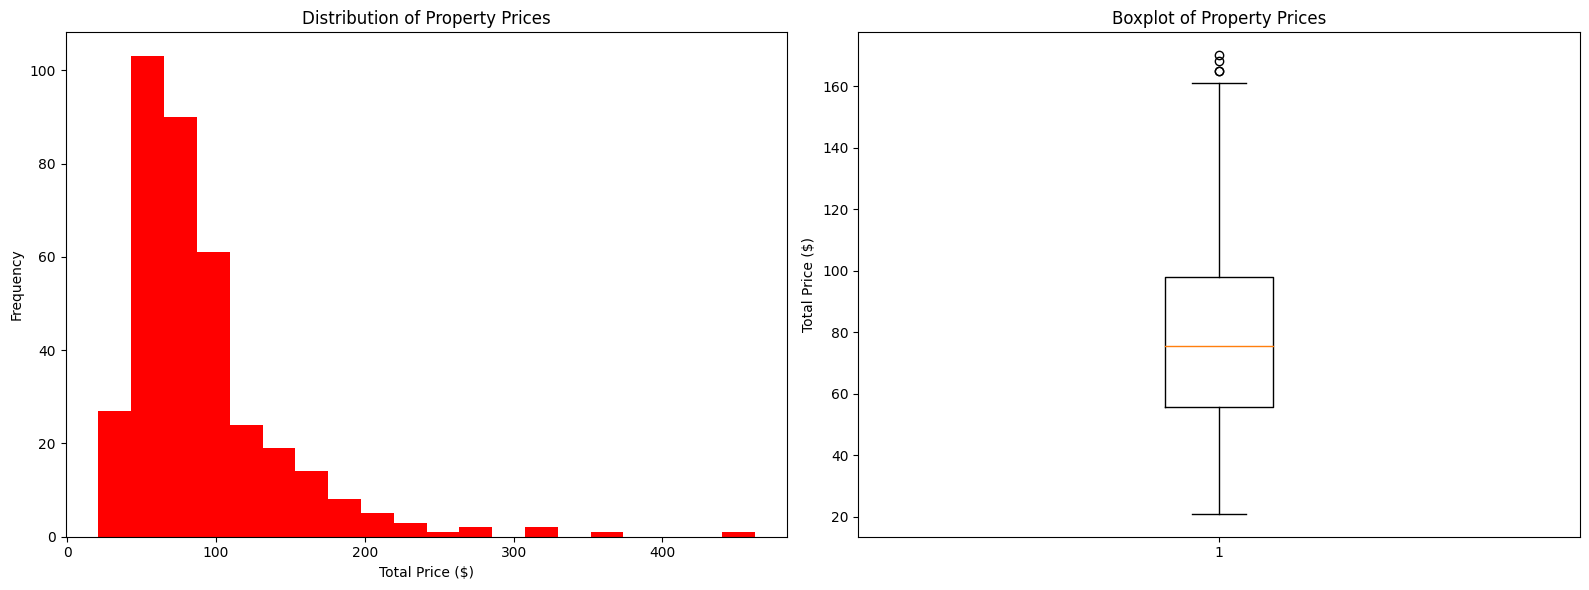

In [148]:
filtered_total_price = properties_dataframe["total price ($)"].dropna()

# Calculating the IQR
Q1 = filtered_total_price.quantile(0.25)
Q3 = filtered_total_price.quantile(0.75)
IQR = Q3 - Q1

# Defining bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out outliers (because some properties have very large prices compared to others, box plot was very compressed)
filtered_df = filtered_total_price[
    (filtered_total_price >= lower_bound) & (filtered_total_price <= upper_bound)
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of prices
axes[0].hist(filtered_total_price, bins=20, color="red")
axes[0].set_xlabel("Total Price ($)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Property Prices")

# Boxplot of prices
axes[1].boxplot(filtered_df)
axes[1].set_ylabel("Total Price ($)")
axes[1].set_title("Boxplot of Property Prices")

plt.tight_layout()
plt.show()

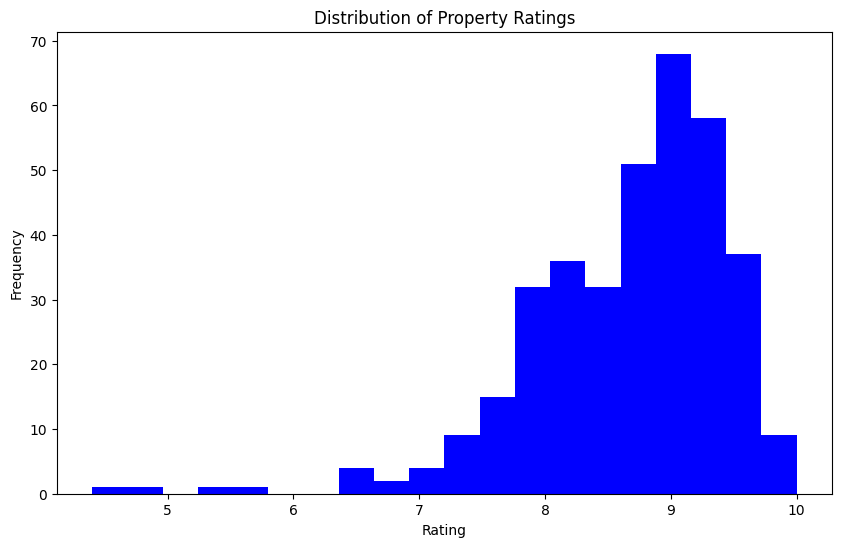

In [149]:
filtered_rating = properties_dataframe["rating"].dropna()

# Histogram of ratings
plt.figure(figsize=(10, 6))
plt.hist(filtered_rating, bins=20, color="blue")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Property Ratings")
plt.show()

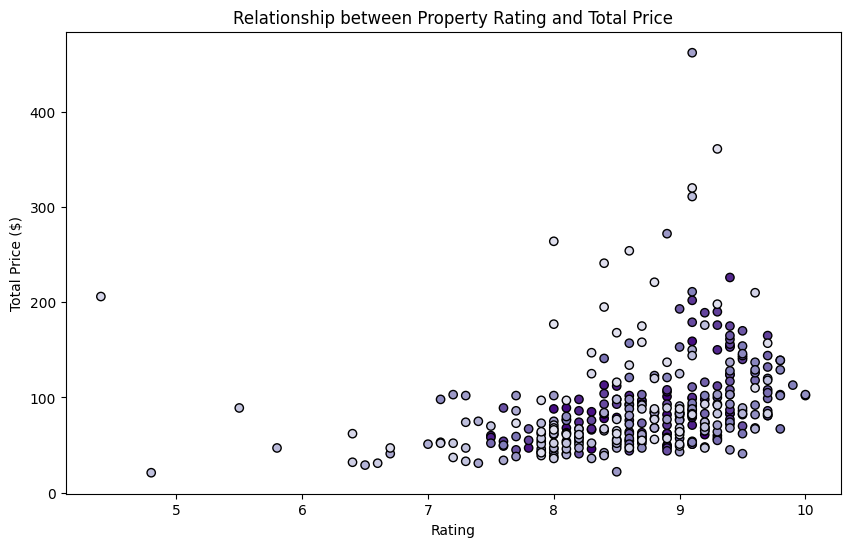

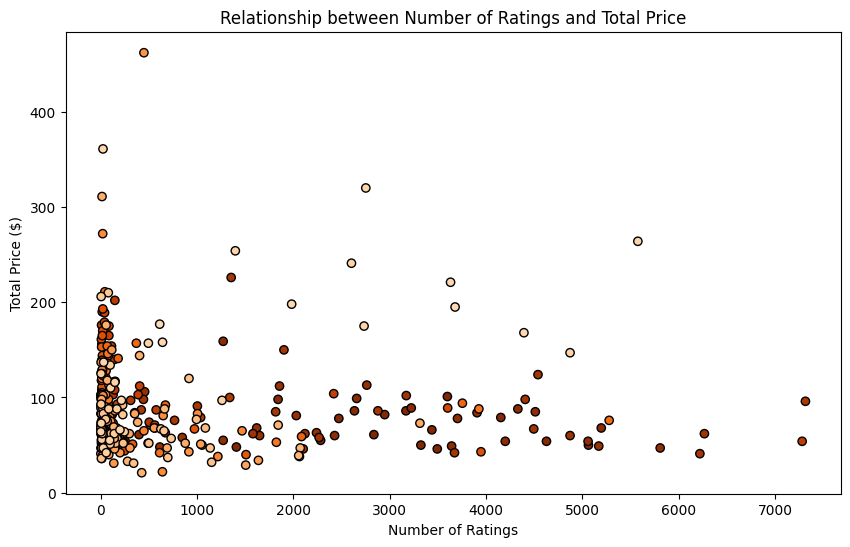

In [150]:
temp_df = properties_dataframe.dropna(subset=["rating", "total price ($)"])
filtered_rating = temp_df["rating"]
filtered_total_price = temp_df["total price ($)"]

# Scatter plot of price vs rating
plt.figure(figsize=(10, 6))
plt.scatter(
    filtered_rating,
    filtered_total_price,
    color=plt.cm.Purples(np.linspace(1, 0.2, len(filtered_rating))),
    edgecolor="black",
)
plt.xlabel("Rating")
plt.ylabel("Total Price ($)")
plt.title("Relationship between Property Rating and Total Price")
plt.show()

temp_df = properties_dataframe.dropna(subset=["number of ratings", "total price ($)"])
filtered_total_price = temp_df["total price ($)"]
filtered_number_of_ratings = temp_df["number of ratings"]

# Scatter plot of number of ratings vs price
plt.figure(figsize=(10, 6))
plt.scatter(
    filtered_number_of_ratings,
    filtered_total_price,
    color=plt.cm.Oranges(np.linspace(1, 0.2, len(filtered_number_of_ratings))),
    edgecolor="black",
)
plt.ylabel("Total Price ($)")
plt.xlabel("Number of Ratings")
plt.title("Relationship between Number of Ratings and Total Price")
plt.show()

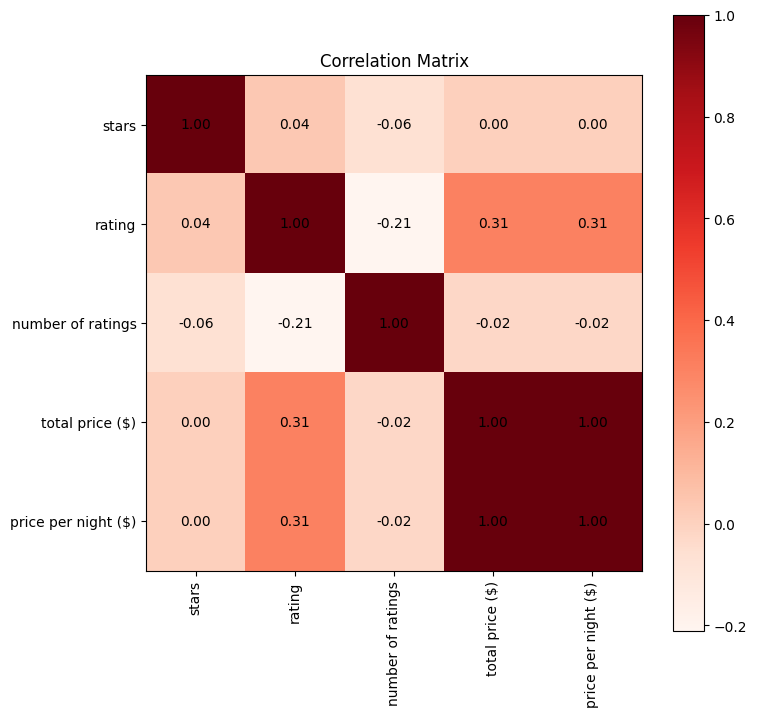

In [151]:
# Correlation matrix
correlation_matrix = no_nan_df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(8, 8))
plt.imshow(correlation_matrix, cmap="Reds", interpolation="nearest")
plt.colorbar()

# Adding the percentages inside the heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(
            j,
            i,
            f"{correlation_matrix.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
        )

plt.xticks(
    range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90
)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Correlation Matrix")
plt.show()

## User interaction

In [152]:
df = no_nan_df

### Filter & Sort Properties

In [153]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Function to filter the DataFrame based on user input
def filter_data(price_range, number_of_ratings_range, rating_range, stars_range):
  filtered_df = df[
      (df['price per night ($)'] >= price_range[0]) & (df['price per night ($)'] <= price_range[1]) &
      (df['number of ratings'].astype(float) >= number_of_ratings_range[0]) & (df['number of ratings'].astype(float) <= number_of_ratings_range[1]) &
      (df['rating'].astype(float) >= rating_range[0]) & (df['rating'].astype(float) <= rating_range[1]) &
      (df['stars'].astype(float) >= stars_range[0]) & (df['stars'].astype(float) <= stars_range[1])
  ]
  return filtered_df

# Function to sort the filtered DataFrame based on user selection
def sort_data(filtered_df, sort_criteria):
  if sort_criteria == 'price per night ($) (Low to High)':
    sorted_df = filtered_df.sort_values('price per night ($)')
  elif sort_criteria == 'price per night ($) (High to Low)':
    sorted_df = filtered_df.sort_values('price per night ($)', ascending=False)
  elif sort_criteria == 'number of ratings (Low to High)':
    sorted_df = filtered_df.sort_values('number of ratings', ascending=True)
  elif sort_criteria == 'number of ratings (High to Low)':
    sorted_df = filtered_df.sort_values('number of ratings', ascending=False)
  elif sort_criteria == 'rating (Low to High)':
    sorted_df = filtered_df.sort_values('rating', ascending=True)
  elif sort_criteria == 'rating (High to Low)':
    sorted_df = filtered_df.sort_values('rating', ascending=False)
  elif sort_criteria == 'stars (Low to High)':
    sorted_df = filtered_df.sort_values('stars', ascending=True)
  elif sort_criteria == 'stars (High to Low)':
    sorted_df = filtered_df.sort_values('stars', ascending=False)
  else:
    sorted_df = filtered_df
  return sorted_df

# Create interactive widgets for filtering
price_range_slider = widgets.IntRangeSlider(
    value=[0, df['price per night ($)'].max()],
    min=0,
    max=df['price per night ($)'].max(),
    step=1,
    description='Price Range:'
)

number_of_ratings_range_slider = widgets.FloatRangeSlider(
    value=[0, df['number of ratings'].astype(float).max()],
    min=0,
    max=df['number of ratings'].astype(float).max(),
    step=0.1,
    description='Number of Ratings Range:'
)

rating_range_slider = widgets.FloatRangeSlider(
    value=[0, df['rating'].astype(float).max()],
    min=0,
    max=df['rating'].astype(float).max(),
    step=0.1,
    description='Rating Range:'
)

stars_range_slider = widgets.FloatRangeSlider(
    value=[0,5],
    min=0,
    max=5,
    step=0.1,
    description='Stars Range:'
)

sort_criteria_dropdown = widgets.Dropdown(
    options=['None',
             'stars (Low to High)', 'stars (High to Low)',
             'price per night ($) (Low to High)', 'price per night ($) (High to Low)',
             'number of ratings (Low to High)', 'number of ratings (High to Low)',
             'Rating (Low to High)', 'Rating (High to Low)'],
    value='None',
    description='Sort By:'
)

apply_button = widgets.Button(description='Apply Filters & Sort')

output = widgets.Output()

def on_button_clicked(b):
  with output:
    clear_output()
    filtered_df = filter_data(price_range_slider.value, number_of_ratings_range_slider.value, rating_range_slider.value, stars_range_slider.value)
    sorted_df = sort_data(filtered_df, sort_criteria_dropdown.value)
    display(sorted_df)


apply_button.on_click(on_button_clicked)

display(price_range_slider, number_of_ratings_range_slider, rating_range_slider, stars_range_slider, sort_criteria_dropdown, apply_button, output)


IntRangeSlider(value=(0, 154), description='Price Range:', max=154)

FloatRangeSlider(value=(0.0, 7317.0), description='Number of Ratings Range:', max=7317.0)

FloatRangeSlider(value=(0.0, 10.0), description='Rating Range:', max=10.0)

FloatRangeSlider(value=(0.0, 5.0), description='Stars Range:', max=5.0)

Dropdown(description='Sort By:', options=('None', 'stars (Low to High)', 'stars (High to Low)', 'price per nig…

Button(description='Apply Filters & Sort', style=ButtonStyle())

Output()

### Property Search

In [154]:
property_name_textbox = widgets.Text(
    placeholder="Enter property name",
    description="Property Name:",
)

search_button = widgets.Button(description="Search")

property_info_output = widgets.Output()


def display_property_info(property_name):
    """Displays property information and images."""
    with property_info_output:
        property_info_output.clear_output()

        matching_property = df[df["name"].str.contains(property_name, case=False)]

        if not matching_property.empty:
            for _, row in matching_property.iterrows():
                property_name = row["name"]
                address = row["address"]
                description = row["description"]
                reviews = row["number of ratings"]
                rating = row["rating"]
                avg_price = row["price per night ($)"]
                image_urls = row["images"]

                display(HTML(f"<h3>Name: {property_name}</h3>"))
                display(HTML(f"<p>Address: {address}</p>"))
                display(HTML(f"<p>Rating: {rating} Number of Reviews: {reviews}</p>"))
                display(HTML(f"<p>Average Price: ${avg_price}</p>"))
                display(HTML(f"<p>Summary: {description}</p>"))

                if image_urls:
                    # Creating an HTML block for all the images in one row
                    images_html = (
                        '<div style="display: flex; flex-wrap: wrap; gap: 10px;">'
                    )
                    for image_url in image_urls:
                      try:
                        response = requests.get(image_url)
                        image = Image.open(io.BytesIO(response.content))
                        image.thumbnail((150, 150))  # Resize images

                        # Saving the image to a temporary in-memory file
                        buffer = io.BytesIO()
                        image.save(buffer, format="PNG")
                        buffer.seek(0)

                        # Converting the image to a base64 string
                        base64_image = base64.b64encode(buffer.getvalue()).decode(
                            "utf-8"
                        )
                        # Appending the image to the HTML block
                        images_html += f'<img src="data:image/png;base64,{base64_image}" style="width: 150px; height: 150px; object-fit: cover;" />'

                      except Exception as e:
                          print(f"Error loading image: {e}")

                    images_html += "</div>"
                    # Displaying all images at once
                    display(HTML(images_html))

        else:
            print("No property found with that name.")


def on_button_clicked(b):
    """Callback function when the search button is clicked."""
    hotel_name = property_name_textbox.value
    display_property_info(hotel_name)


search_button.on_click(on_button_clicked)

display(property_name_textbox, search_button, property_info_output)

Text(value='', description='Property Name:', placeholder='Enter property name')

Button(description='Search', style=ButtonStyle())

Output()